In [30]:
import warnings
warnings.filterwarnings('ignore')

# Utils

In [2]:
from random import randint
import xml.etree.ElementTree as ET


def random_color():
    r = randint(0, 255)
    g = randint(0, 255)
    b = randint(0, 255)    
    return (r, g, b)

def xml2list(xml_path):
    #print("xml to csv {}".format(xml_path))
    xml_list = []
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for member in root.findall('object'):
            tag = str(member.findall('name')[0].text)
            xmin = int(member.findall('bndbox')[0].findall('xmin')[0].text)
            ymin = int(member.findall('bndbox')[0].findall('ymin')[0].text)
            xmax = int(member.findall('bndbox')[0].findall('xmax')[0].text)
            ymax = int(member.findall('bndbox')[0].findall('ymax')[0].text)

            xml_list.append({
                tag: (xmin, ymin, xmax, ymax)
            })      
    except Exception as e:
        print('xml conversion failed:{}'.format(e))
    return xml_list

# config

In [3]:
export_video = False

# Prepare dataset

In [4]:
import os
import cv2

In [5]:
DATASET = "Tailandia"
# serverstorage/Almacenamiento I+D+i/Proyectos/04.01.02 Proyectos en Curso/IA/20220927 FD-Image/20221111 Tracking-Vehicles/data/Tailandia/Tailandia
FOLDER = "/serverstorage/Tailandia"

In [6]:
images = []
xml = []
for file in os.listdir(FOLDER):
    name, extension = file.split(".")
    if extension.find("xml")>=0:
        xml.append(name)
    else:
        images.append(file)

images.sort()

images[:5], xml[:5]

(['Tailandia 001.jpg',
  'Tailandia 002.jpg',
  'Tailandia 003.jpg',
  'Tailandia 004.jpg',
  'Tailandia 005.jpg'],
 ['Tailandia 035',
  'Tailandia 219',
  'Tailandia 143',
  'Tailandia 029',
  'Tailandia 125'])

In [7]:
all_images = []
all_names = []
vehicles = {}

In [8]:
sizes_images = []

for i, image in enumerate(images):

    image = os.path.join(FOLDER, image)
    file, extension = image.split(".")

    image = cv2.imread(image)    
    
    tags = None
    try:  
        xml_to_search = file.split(os.sep)[-1]
        id_xml = xml.index(xml_to_search)   
        file_xml = os.path.join(FOLDER, xml[id_xml]+".xml")
        tags = xml2list(file_xml)   
    except Exception as e:        
        pass

    if tags:
        shape = '-'.join(str(e) for e in  list(image.shape))
        if shape not in sizes_images:
            sizes_images.append(shape)
            
        for tag in tags:
            for k, (xmin, ymin, xmax, ymax) in tag.items():     
                file_xml = file.split(os.sep)[-1]
                try:
                    time_frame = int(file_xml.split(" ")[-1])
                    pass
                except:
                    time_frame = int(file_xml.split("ing")[-1])
                    pass

                if time_frame:
                    name_vehicle, type_vehicle = k.split("_")
                    #print(name_vehicle, type_vehicle, time_frame)
    
                    color = (255, 0, 0)  # Blue color in BGR                
                    thickness = 2  # Line thickness of 2 px
                    image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)
        
                    center_coordinates = xmin + int((xmax-xmin)/2), ymin + int((ymax-ymin)/2)
                    radius = 20
                    color = (0, 0, 255)
                    thickness = 2
                    image = cv2.circle(image, center_coordinates, radius, color, thickness)
        
                    fontScale = 1
                    color = (255, 0, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, name_vehicle, (xmin, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    fontScale = 1
                    color = (0, 0, 255)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, str(time_frame), (xmax, ymax), font, fontScale, color, thickness, cv2.LINE_AA)
        
                    fontScale = 1
                    color = (0, 255, 0)
                    thickness = 2
                    font = cv2.FONT_HERSHEY_SIMPLEX
                    image = cv2.putText(image, str(type_vehicle), (xmax, ymin), font, fontScale, color, thickness, cv2.LINE_AA)
    
                    bbox_area = ( xmax - xmin ) * ( ymax - ymin )
    
                    if name_vehicle not in vehicles:
                        vehicles[name_vehicle] = []
                        all_names.append(name_vehicle)
    
                    vehicles[name_vehicle].append(
                        {
                            "center": center_coordinates,
                            "area": bbox_area,
                            "frame_id": i,
                            "shape": image.shape,
                            "cam": 0,
                            "type_vehicle": type_vehicle,
                            "time": time_frame,
                            "file": file
                        }
                    )
        
                    all_names.append(name_vehicle)
    all_images.append(image)
    #break


height,width,layers = all_images[0].shape

## export complete video

In [9]:
if export_video:
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 

    video = cv2.VideoWriter(f"/serverstorage/{DATASET}.avi", fourcc, 1, (width,height))

    for i, image in enumerate(all_images):
        video.write(image)

    cv2.destroyAllWindows()
    video.release()

## graph

In [10]:
import matplotlib.pyplot as plt

### Escenario

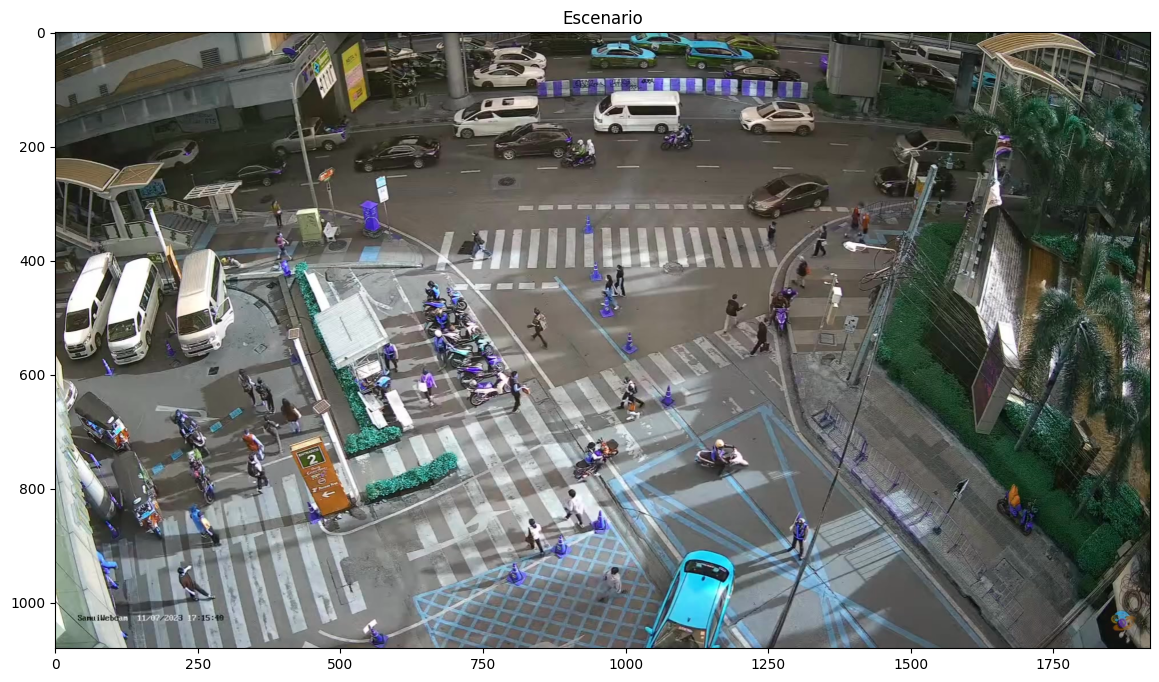

In [11]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)

plt.figure(figsize=(20,8))
plt.title('Escenario')
plt.imshow(fondo)
plt.show()

### all moves

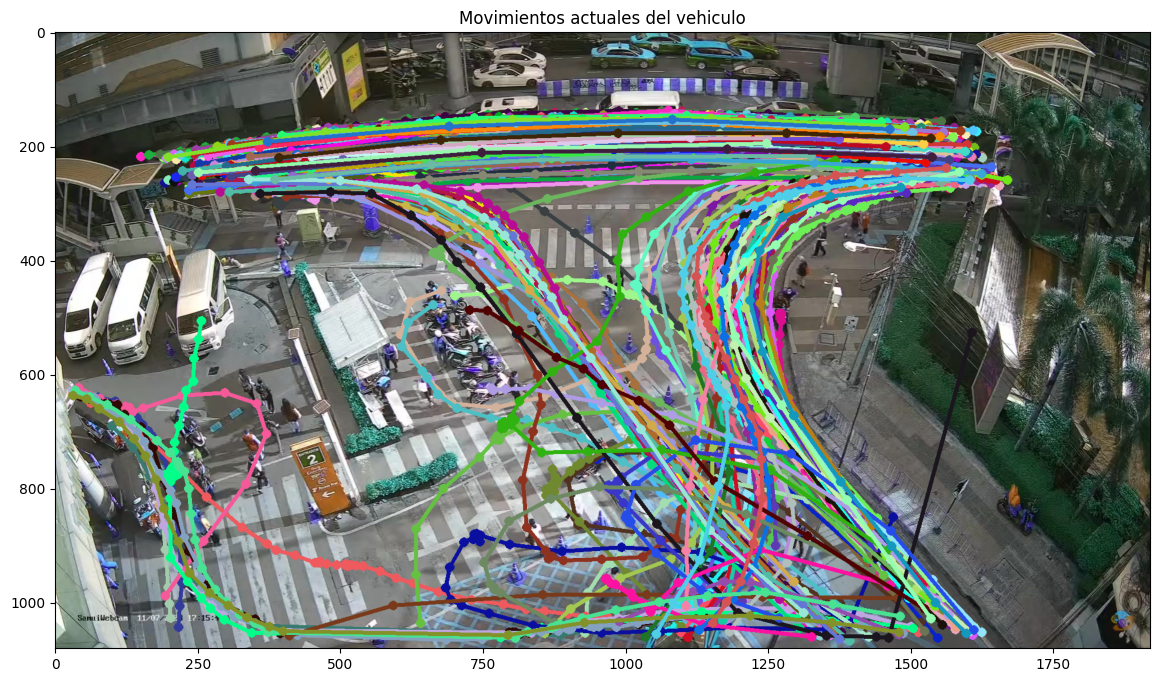

In [12]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = [ id["type_vehicle"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        desde = coordinate
        hasta = coordinates[i+1]
        fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo')
plt.imshow(fondo)
plt.show()

### car moves

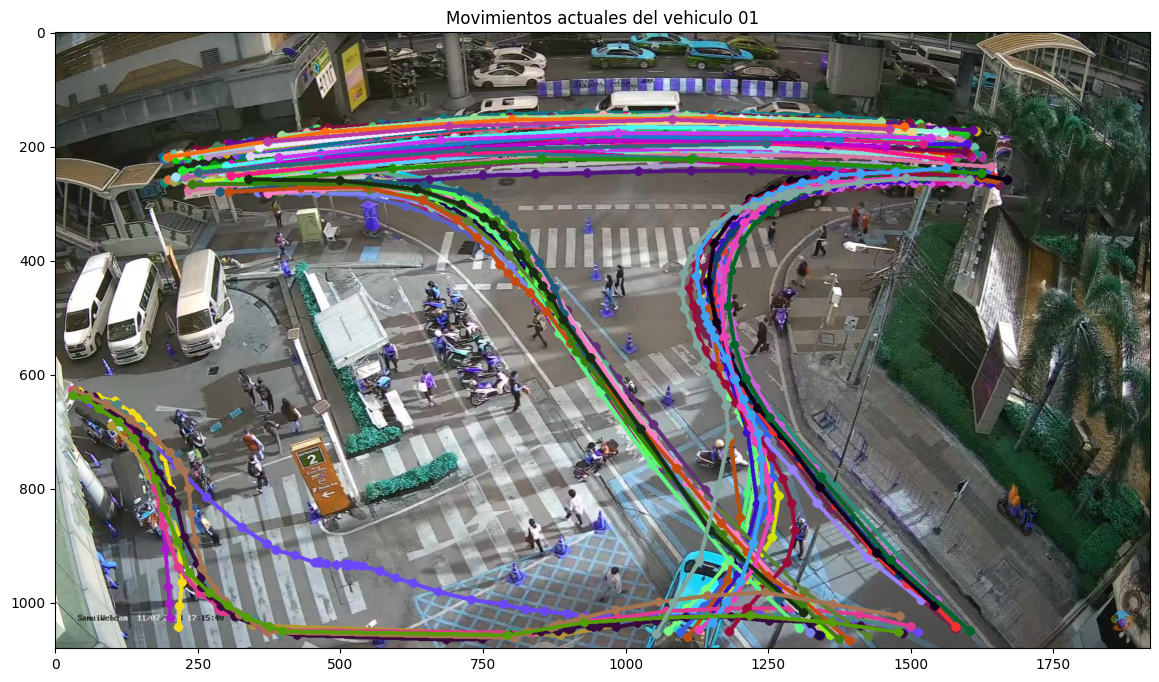

In [13]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

type_vehicle_graph = "01"

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = [ id["type_vehicle"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        if type_vehicle[i] == type_vehicle_graph:
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        if type_vehicle[i] == type_vehicle_graph:
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo {type_vehicle_graph}')
plt.imshow(fondo)
plt.show()

### motorbite moves

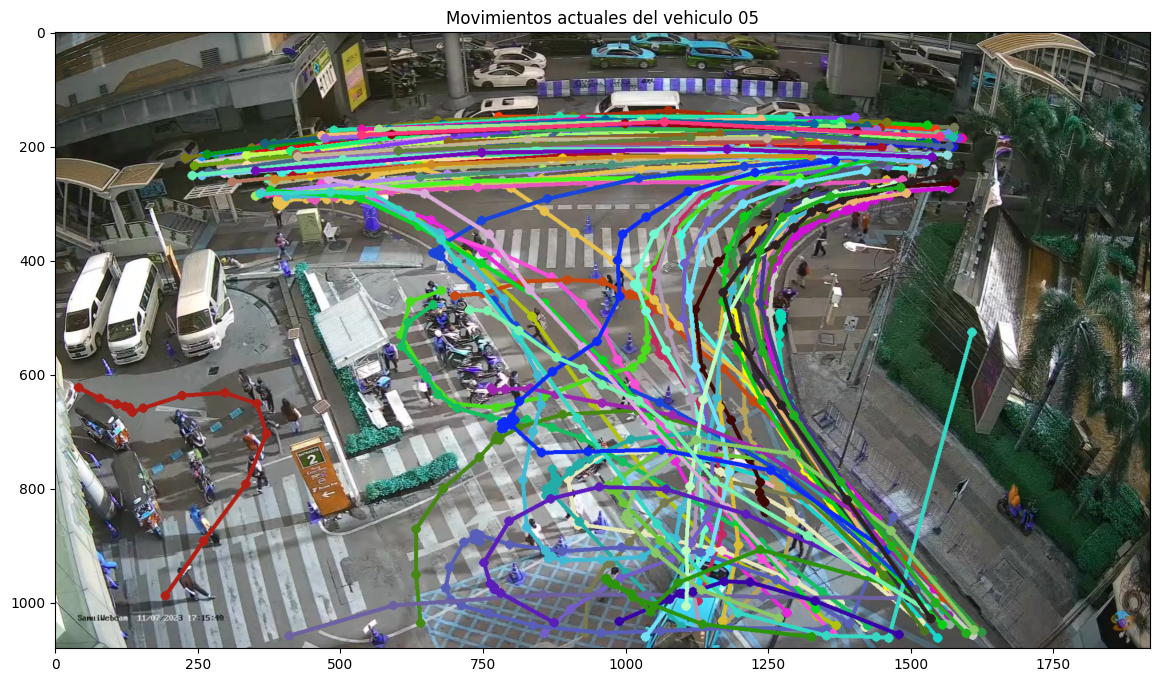

In [14]:
fondo = "/serverstorage/2023-03-24 10-02-19/2023-03-24 10-02-19 001.jpg"
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
#fondo = "/serverstorage/Cibeles/2023-07-11 12-38-25 034.jpg"
fondo = cv2.imread(fondo)
#fondo = 255*np.ones([height, width, 3], np.uint8)

radius = 5
thickness = 5

type_vehicle_graph = "05"

for name_car in all_names:
    
    color = random_color()

    # order centers by coordinates
    coordinates_noOrder = [ id["center"] for id in vehicles[name_car] ]
    type_vehicle = [ id["type_vehicle"] for id in vehicles[name_car] ]
    # order first position 1 and after by postiion 0
    coordinates = sorted(coordinates_noOrder , key=lambda k: [k[1], k[0]]) 
    coordinates = coordinates_noOrder
    
    for i, coordinate in enumerate(coordinates):
        if type_vehicle[i] == type_vehicle_graph:
            fondo = cv2.circle(fondo, coordinate, radius, color, thickness)

    for i, coordinate in enumerate(coordinates[:-1]):
        # print(feature["frame_id"], vehicles[name_car][i+1]["frame_id"])
        if type_vehicle[i] == type_vehicle_graph:
            desde = coordinate
            hasta = coordinates[i+1]
            fondo = cv2.line(fondo, desde, hasta , color, thickness )
        

plt.figure(figsize=(20,8))
plt.title(f'Movimientos actuales del vehiculo {type_vehicle_graph}')
plt.imshow(fondo)
plt.show()

# extract vehicle of dataset

In [15]:
type_vehicles_to_process = [
    "01",
    #"05"
]

nombres = []
for i, name_car in enumerate(all_names):
    type_vehicle = vehicles[name_car][0]["type_vehicle"]
    if type_vehicle in type_vehicles_to_process:
        nombres.append(name_car)

nombres = list(set(nombres))

# states_for_machine

In [16]:
from states_for_machine.extend_data import ExtendData

In [17]:
from states_for_machine.extra_features import ExtraFeatures

In [18]:
from states_for_machine.individual_anomaly import IndividualAnomaly

# create state machine

In [19]:
from state_machine.Machine import Machine

In [20]:
class Brain:

    @property
    def machine(self):
        return Machine(state=[
                ExtendData(next_state="ExtraFeatures"), 
                ExtraFeatures(next_state="IndividualAnomaly"),
                IndividualAnomaly(next_state=None)
            ], initial='ExtendData')

## execute state machine

In [21]:
name_car = nombres[1]
data_to_process = vehicles[name_car]

data = {
    "data": data_to_process,
    "size_frame": (height,width)  # visual reference or observation point
}

name_car, len(data_to_process)

('0282', 6)

In [22]:
maquina = Brain().machine
result = maquina.cicle(**data)
#result["features"]

/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
result["anomaly"]["individual"]['summary'], result["anomaly"]["individual"]['there_are']

([1, 2, 1, 1, 1, 2], True)

# apply over all dataset 

In [58]:
dataset = {}
for i in range(6):
    dataset[i] = []

for name_car, tracking_vehicle in  vehicles.items():
      
    aproved_vehicles = []
    for data_to_process in tracking_vehicle:
        if data_to_process["type_vehicle"] in type_vehicles_to_process:
            aproved_vehicles.append(data_to_process)

    if len(aproved_vehicles)>0:
        data = {
            "data": aproved_vehicles,
            "size_frame": (height,width)  # visual reference or observation point
        }
        maquina = Brain().machine
        result = maquina.cicle(**data)

        try:
            #result["features"]["features_df"].to_csv(f"/serverstorage/dataset_tailandia/{name_car}.csv")
            
            df = result["features"]["features_df"]
            df = df.drop('original_coordinate_x', axis=1)
            df = df.drop('original_coordinate_y', axis=1)
            
            for key in dataset.keys():
                condition = df['quadrants'] == key
                if list(set(condition))[0]:
                    df_filer = df[condition]
                    df_filer = df_filer.drop('quadrants', axis=1)
                    dataset[key].append(df_filer.values) 
            #break
        except Exception as e:
            print(e)
            #print(result)
            #break
            pass
            


: Error: 'times' - details: Traceback (most recent call last):
  File "/tf/state_machine/Machine.py", line 100, in cicle
    kwargs = self.execute(**kwargs)
  File "/tf/state_machine/Machine.py", line 86, in execute
    return self.current(**kwargs)
  File "/tf/state_machine/State.py", line 44, in __call__
    return self.execute(**kwargs)
  File "/tf/states_for_machine/extra_features.py", line 41, in execute
    if not kwargs["coordinates"]["futures"]["times"]:
KeyError: 'times'

'features'


In [66]:
for i in range(6):
    print(len(dataset[i]))

0
0
0
5
17
0


In [57]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('pca', PCA(0.95))           
])

dataset_transformed = pipeline.fit_transform(dataset[0])
len(dataset_transformed)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [36]:
import numpy as np
np.array(dataset)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (170,) + inhomogeneous part.

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('pca', PCA(0.95))           
])

dataset_transformed = pipeline.fit_transform(dataset)
len(dataset_transformed)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (170,) + inhomogeneous part.

In [25]:
#result["features"]["features_df"]

# eval code

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [27]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  
    ('pca', PCA(0.95))           
])

In [28]:
arr = result["features"]["features_np"]
arr_transformed = pipeline.fit_transform(arr)
arr_transformed[0]

KeyError: 'features'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

data = arr_transformed

silhouette_tmp = []
inertias = []

for k in range(2, 10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit_predict(data)
    
    score = silhouette_score(data, km.labels_, metric='euclidean')
    
    silhouette_tmp.append(score)
    inertias.append(km.inertia_)

best_k = np.argmax(silhouette_tmp) + 2

print("Mejor valor de k:", best_k)

plt.plot(range(2, 10), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show() 

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
k=2

spectral_clustering = SpectralClustering(n_clusters=k, random_state=42)
spectral_clustering.fit(arr_transformed)
labels = spectral_clustering.labels_

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(arr_transformed)

predictions = []
for data in result["features"]["features_np"]:
    data_pipe = pipeline.transform([ data ])
    predict = kmeans.predict(data_pipe)[0]
    predictions.append(predict)
    
points = [ obj["center"] for obj in result["data"] ] 

list(zip(predictions, result["anomaly"]["individual"]['summary'], labels, points))

In [ ]:
import cv2

In [ ]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)

# Extraer las coordenadas x e y por separado
x = [coord[0] for coord in points]
y = [coord[1] for coord in points]

# Graficar los puntos
for i in range(len(points)):
    if predictions[i] > 0:
        color = "red"
    else:
        color = "gray"
    plt.scatter(x[i], y[i], color=color)

# Unir los puntos con líneas
for i in range(len(points) - 1):
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 'b-')

# Configurar los ejes y etiquetas
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Graficar Coordenadas Kmeans')
plt.grid(True)

# Mostrar el gráfico
plt.imshow(fondo)
plt.show()

In [ ]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)

# Extraer las coordenadas x e y por separado
x = [coord[0] for coord in points]
y = [coord[1] for coord in points]

predictions = result["anomaly"]["individual"]['summary']
ref = max(predictions) - min(predictions)

# Graficar los puntos
for i in range(len(points)):
    if predictions[i] > ref:
        color = "red"
    else:
        color = "gray"
    plt.scatter(x[i], y[i], color=color)

# Unir los puntos con líneas
for i in range(len(points) - 1):
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 'b-')

# Configurar los ejes y etiquetas
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Graficar Coordenadas Anomalia individual por estadistica')
plt.grid(True)

# Mostrar el gráfico
plt.imshow(fondo)
plt.show()

In [ ]:
fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)

# Extraer las coordenadas x e y por separado
x = [coord[0] for coord in points]
y = [coord[1] for coord in points]

# Graficar los puntos
for i in range(len(points)):
    if labels[i] > 0:
        color = "red"
    else:
        color = "gray"
    plt.scatter(x[i], y[i], color=color)

# Unir los puntos con líneas
for i in range(len(points) - 1):
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 'b-')

# Configurar los ejes y etiquetas
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.title('Graficar Coordenadas SpectralClustering')
plt.grid(True)

# Mostrar el gráfico
plt.imshow(fondo)
plt.show()

In [ ]:
linea1 = [ id["center"] for id in vehicles["0197"] ] 
linea2 = [ id["center"] for id in vehicles["0311"] ] 

In [ ]:
split = 15

for i in range(0, len(list(vehicles.keys())), split):
    bloque = list(vehicles.keys())[i:i+split]
    print(bloque)

In [ ]:
linea1 = [ id["center"] for id in vehicles["0197"] ] 
linea2 = [ id["center"] for id in vehicles["0311"] ] 


import matplotlib.pyplot as plt
from shapely.geometry import Polygon

def comparar_graficar_dos_lineas(linea1, linea2, arrow_length=30, title=""):
    # Unir las dos listas en una sola y revertir la segunda línea
    coordenadas_poligono = linea1 + linea2[::-1]

    # Crear el objeto Polygon
    poly = Polygon(coordenadas_poligono)

    # Calcular el área del polígono (parte sombreada)
    area_sombreada = poly.area
    print("El área de la parte sombreada es:", area_sombreada)

    # Extraer las coordenadas x e y de cada línea
    x_linea1, y_linea1 = zip(*linea1)
    x_linea2, y_linea2 = zip(*linea2)

    # Crear el gráfico
    plt.plot(x_linea1, y_linea1, 'bo-', label='Linea 1')  # 'bo-' representa blue color, círculos, y líneas sólidas
    plt.plot(x_linea2, y_linea2, 'go-', label='Linea 2')  # 'go-' representa green color, círculos, y líneas sólidas

    # Dibujar flechas que indican la trayectoria de cada línea
    #arrow_length = 50  # Longitud de las flechas
    for i in range(1, len(x_linea1)):
        dx1 = x_linea1[i] - x_linea1[i-1]
        dy1 = y_linea1[i] - y_linea1[i-1]
        dx2 = x_linea2[i] - x_linea2[i-1]
        dy2 = y_linea2[i] - y_linea2[i-1]
        plt.arrow(x_linea1[i-1], y_linea1[i-1], dx1, dy1, head_width=arrow_length, head_length=arrow_length, fc='blue', ec='blue')
        plt.arrow(x_linea2[i-1], y_linea2[i-1], dx2, dy2, head_width=arrow_length, head_length=arrow_length, fc='green', ec='green')

    # Sombrear el interior del polígono
    plt.fill(x_linea1 + x_linea2[::-1], y_linea1 + y_linea2[::-1], alpha=0.3)

    # Etiquetas de ejes y leyenda
    plt.xlabel('Coordenada X')
    plt.ylabel('Coordenada Y')
    plt.legend()

    # Título y mostrar el gráfico
    plt.title(title)
    plt.show()

    # Calcular el área del polígono (parte sombreada)
    print("El área de la parte sombreada es:", poly.area)

    # Comprobar si tienen trayectoria similar
    puntos_a_comparar = 3
    umbral_angulo = 0.1
    son_similares = tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar, umbral_angulo)
    print("¿Tienen trayectoria similar?", son_similares)

In [ ]:
import math

def calcular_angulo(punto1, punto2):
    # Calcular el ángulo de inclinación entre dos puntos (en radianes)
    dx = punto2[0] - punto1[0]
    dy = punto2[1] - punto1[1]
    return math.atan2(dy, dx)

def tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar=5, umbral_angulo=0.1):
    # Comprobar si dos líneas tienen trayectoria similar
    if len(linea1) != len(linea2):
        return False
    
    # Tomar un número específico de puntos a lo largo de ambas líneas para comparar
    puntos_comparar_l1 = linea1[:puntos_a_comparar]
    puntos_comparar_l2 = linea2[:puntos_a_comparar]

    # Calcular los ángulos de inclinación para los puntos de cada línea
    angulos_l1 = [calcular_angulo(puntos_comparar_l1[i], puntos_comparar_l1[i+1]) for i in range(len(puntos_comparar_l1)-1)]
    angulos_l2 = [calcular_angulo(puntos_comparar_l2[i], puntos_comparar_l2[i+1]) for i in range(len(puntos_comparar_l2)-1)]

    # Comprobar si los ángulos son similares dentro de un umbral dado
    angulos_similares = all(abs(angulos_l1[i] - angulos_l2[i]) < umbral_angulo for i in range(len(angulos_l1)))

    return angulos_similares

In [ ]:
linea1 = [ id["center"] for id in vehicles["0197"] ] 
linea2 = [ id["center"] for id in vehicles["0311"] ] 


# Comprobar si tienen trayectoria similar
puntos_a_comparar = 3
umbral_angulo = 0.1
son_similares = tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar, umbral_angulo)
print("¿Tienen trayectoria similar?", son_similares)

In [ ]:
type_vehicles_to_process
[ id["type_vehicle"] for id in vehicles[actual] ]
[ id["center"] for id in vehicles[siguiente]  if id["type_vehicle"] in type_vehicles_to_process  ] 

In [ ]:
import random

def generar_color_aleatorio():
    # Generar tres valores aleatorios entre 0 y 1 para las componentes RGB
    red = random.random()
    green = random.random()
    blue = random.random()

    # Devolver una tupla que representa el color
    return (red, green, blue)

import matplotlib.pyplot as plt

fondo = "/serverstorage/Tailandia/Tailandia 001.jpg"
fondo = cv2.imread(fondo)


def graficar_semejantes(a_graficar):

    for n, sem in a_graficar.items():
        color_linea = generar_color_aleatorio()

        linea1 = [ id["center"] for id in vehicles[n] ]    
        x_linea1, y_linea1 = zip(*linea1)  # Extraer las coordenadas x e y de cada línea        
        plt.plot(x_linea1, y_linea1, color=color_linea, label='Linea 1', linestyle='-', linewidth=2)
        plt.scatter(x_linea1, y_linea1, color=color_linea, s=100, zorder=5)

        if len(sem) > 0:

            for _, s in enumerate(sem): 

                linea2 = [ id["center"] for id in vehicles[s] ] 
                x_linea2, y_linea2 = zip(*linea2)  # Extraer las coordenadas x e y de cada línea
                plt.plot(x_linea2, y_linea2, color=color_linea, label='Linea 2', linestyle='-', linewidth=2)
                plt.scatter(x_linea2, y_linea2, color=color_linea, s=100, zorder=5)

                # Dibujar trayectoria de cada línea con flechas
                """for i in range(len(linea1)-1):
                    dx1 = x_linea1[i+1] - x_linea1[i]
                    dy1 = y_linea1[i+1] - y_linea1[i]
                    dx2 = x_linea2[i+1] - x_linea2[i]
                    dy2 = y_linea2[i+1] - y_linea2[i]
                    plt.arrow(x_linea1[i], y_linea1[i], dx1, dy1, head_width=30, head_length=20, fc=color_linea, ec=color_linea)
                    plt.arrow(x_linea2[i], y_linea2[i], dx2, dy2, head_width=30, head_length=20, fc=color_linea, ec=color_linea)
                """


                # Dibujar flechas que indican la trayectoria de cada línea
                arrow_length = 0.2  # Longitud de las flechas

            #break

    # Etiquetas de ejes y leyenda
    #plt.legend()

    # Título y mostrar el gráfico
    plt.title('Gráfico de las dos líneas')
    plt.imshow(fondo)
    plt.show()

In [ ]:
all_vehicles = list(vehicles.keys())

puntos_a_comparar = 3
umbral_angulo = 0.5

semejantes = {}
for i, actual in enumerate(all_vehicles):      
    linea1 = [ id["center"] for id in vehicles[actual] if id["type_vehicle"] in type_vehicles_to_process ] 
    
    if len(linea1) > 0:
        for j in range(i+1, len(all_vehicles), 1):
            siguiente = all_vehicles[j]       

            linea2 = [ id["center"] for id in vehicles[siguiente]  if id["type_vehicle"] in type_vehicles_to_process  ] 

            if len(linea2) > 0:
                if tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar, umbral_angulo):
                    if actual not in semejantes:
                        semejantes[actual] = []
                    semejantes[actual].append(siguiente)
    
    
semejante_real = {}
abandonados = {}

for n, sem in semejantes.items():
        
    if len(sem) == 0:
        if n not in abandonados:
            abandonados[n] = []
    else:    
        nuevo = True
        if n not in semejante_real:
            
            for k, v in semejante_real.items():
                if n in v:
                    nuevo = False
                    break
                    
            if nuevo:
                semejante_real[n] = []
        if nuevo:
            for k in sem:
                semejante_real[n].append(k)

                if k in semejantes:
                    hermanos = semejantes[k]
                    for her in hermanos:
                        semejante_real[n].append(her)
                    

for k, v in semejante_real.items():
    semejante_real[k] = list(set(v))
    

print(len(semejante_real), len(abandonados))

graficar_semejantes(semejante_real)

In [ ]:
all_vehicles = list(vehicles.keys())

puntos_a_comparar = 3
umbral_angulo = 0.5

for umbral_angulo in [i * 0.05 for i in range(100,500,2)]:    

    semejantes = {}
    for i, actual in enumerate(all_vehicles):      
        linea1 = [ id["center"] for id in vehicles[actual] if id["type_vehicle"] in type_vehicles_to_process ] 

        if len(linea1) > 0:
            for j in range(i+1, len(all_vehicles), 1):
                siguiente = all_vehicles[j]       

                linea2 = [ id["center"] for id in vehicles[siguiente]  if id["type_vehicle"] in type_vehicles_to_process  ] 

                if len(linea2) > 0:
                    if tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar, umbral_angulo):
                        if actual not in semejantes:
                            semejantes[actual] = []
                        semejantes[actual].append(siguiente)


    semejante_real = {}
    abandonados = {}

    for n, sem in semejantes.items():

        if len(sem) == 0:
            if n not in abandonados:
                abandonados[n] = []
        else:    
            nuevo = True
            if n not in semejante_real:

                for k, v in semejante_real.items():
                    if n in v:
                        nuevo = False
                        break

                if nuevo:
                    semejante_real[n] = []
            if nuevo:
                for k in sem:
                    semejante_real[n].append(k)

                    if k in semejantes:
                        hermanos = semejantes[k]
                        for her in hermanos:
                            semejante_real[n].append(her)


    for k, v in semejante_real.items():
        semejante_real[k] = list(set(v))


    print(f"puntos_a_comparar: {puntos_a_comparar}", f" - umbral_angulo {umbral_angulo}", (len(semejantes), len(semejante_real), len(abandonados)))

    graficar_semejantes(semejante_real)

In [ ]:
graficar_semejantes(abandonados)

In [ ]:
import matplotlib.pyplot as plt

# Define x and y data
x = [1, 2, 3, 4, 5]
y = [1, 2, 3, 4, 5]

# Define custom RGB color as a tuple
custom_color = (0.5, 0.1, 0.7)

# Plot line with custom color
plt.plot(x, y, color=custom_color)

# Show plot
plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt

def generar_color_aleatorio():
    # Generar tres valores aleatorios entre 0 y 1 para las componentes RGB
    red = random.random()
    green = random.random()
    blue = random.random()

    # Devolver una tupla que representa el color
    return (red, green, blue)

# Definir las líneas
linea1 = [(1512, 184), (1226, 175), (894, 183), (574, 205), (329, 228)]
linea2 = [(1311, 1018), (1147, 873), (1026, 696), (938, 571), (890, 504), (870, 465), (854, 445), (838, 421), (814, 390), (787, 356), (768, 338), (751, 325), (712, 302), (633, 275), (499, 260), (339, 258)]

# Generar colores aleatorios para las líneas y los puntos
color_linea1 = generar_color_aleatorio()
color_linea2 = generar_color_aleatorio()

# Coordenadas de los puntos de cada línea
x_linea1, y_linea1 = zip(*linea1)
x_linea2, y_linea2 = zip(*linea2)

# Crear el gráfico con las líneas de colores aleatorios y puntos unidos
plt.plot(x_linea1, y_linea1, color=color_linea1, label='Linea 1', marker='o', linestyle='-', linewidth=2)
plt.plot(x_linea2, y_linea2, color=color_linea2, label='Linea 2', marker='o', linestyle='-', linewidth=2)

# Dibujar puntos en las coordenadas especificadas y resaltarlos con un tamaño mayor
plt.scatter(x_linea1, y_linea1, color=color_linea1, s=100, zorder=5)
plt.scatter(x_linea2, y_linea2, color=color_linea2, s=100, zorder=5)

# Dibujar trayectoria de cada línea con flechas
for i in range(len(linea1)-1):
    dx1 = x_linea1[i+1] - x_linea1[i]
    dy1 = y_linea1[i+1] - y_linea1[i]
    dx2 = x_linea2[i+1] - x_linea2[i]
    dy2 = y_linea2[i+1] - y_linea2[i]
    plt.arrow(x_linea1[i], y_linea1[i], dx1, dy1, head_width=30, head_length=20, fc=color_linea1, ec=color_linea1)
    plt.arrow(x_linea2[i], y_linea2[i], dx2, dy2, head_width=30, head_length=20, fc=color_linea2, ec=color_linea2)

# Etiquetas de ejes y leyenda
plt.xlabel('Eje X')
plt.ylabel('Eje Y')
plt.legend()

# Título y mostrar el gráfico
plt.title('Gráfico de dos líneas con puntos, trayectoria y flechas')
plt.grid(True)
plt.show()


In [ ]:
    
for n, sem in semejantes.items():
    cantidad_semejantes = len(sem)
    for i, s in enumerate(sem): 
        linea1 = [ id["center"] for id in vehicles[actual] ] 
        linea2 = [ id["center"] for id in vehicles[s] ] 

        if tienen_trayectoria_similar(linea1, linea2, puntos_a_comparar, umbral_angulo):
            comparar_graficar_dos_lineas(linea1, linea2, title=f"{actual} - {s} ({i}/{cantidad_semejantes})")
        
        
        break
    
